# Purpose: Use dimensions.ai as the source of summary statistics of research publication by category, try to identify categories with highest growth (hence more potential)
last updated on 3/20/2023
1. Collect research cateogies and codes from https://app.dimensions.ai/browse/categories/publication/for
2. Visit each catogory and crawl research data
3. Analyze growth trend and compare across time and different sectors

References: 
1. https://towardsdatascience.com/how-to-use-selenium-to-web-scrape-with-example-80f9b23a843a

In [ ]:
import requests
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import re
HEADERS = ({'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) \AppleWebKit/537.36 (KHTML, like Gecko) \Chrome/90.0.4430.212 Safari/537.36','Accept-Language': 'en-US, en;q=0.5'})

In [ ]:
def get_soup(url,HEADERS):
    r = requests.get(url, headers=HEADERS).text
#     soup = BeautifulSoup(r, 'html.parser')
    soup = BeautifulSoup(r, 'lxml')
    return soup
soup= get_soup("https://app.dimensions.ai/browse/categories/publication/for",HEADERS)

In [ ]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

soup = BeautifulSoup(urlopen("https://app.dimensions.ai/browse/categories/publication/for"))
result = soup.find_all("div", {"class":"mycategories"})

for res in result:
    print(res.decode_contents().strip())

Note: used selenium instead of BeautifulSoup because the category data was loaded after loading the site

In [1]:
# use the latest selenium 4, there are syntax changes from previous version
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pickle

In [ ]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

In [ ]:
driver.get("https://app.dimensions.ai/browse/categories/publication/for")

In [ ]:
all_href = driver.find_elements(By.XPATH,  "//*[contains(@href, '/discover/publication?and_facet_for')]")

In [ ]:
# Find by div class failed because can't collect the href links
# level_1 = driver.find_elements("xpath",'//div[@class="sc-2f5ewc-3 bVEbpe textcrop"]')
# level_2 = driver.find_elements("xpath",'//div[@class="sc-2f5ewc-0 gIuuzb textcrop"]')

In [ ]:
research_collection = {}
for i in range(len(all_href)):
    research_collection[all_href[i].text] = all_href[i].get_attribute('href')

In [ ]:
research_data = {}
for item in list(research_collection.items()):
    name, link = item[0],item[1]
    driver.get(link.replace("discover/publication?","analytics/publication/overview/timeline?"))
    WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//*[@id='analytics_infinite_scroll_container']/div[2]/div[2]/div[2]/div[2]/fieldset/span[3]"))).click()
    WebDriverWait(driver, 10)
    # Reference: https://www.softwaretestingmaterial.com/how-to-handle-web-tables-in-selenium-python/
    columns_header = driver.find_elements(By.XPATH,"//table[@class= 'table table--analytical']/thead/tr/th")
#     row_header = driver.find_elements(By.XPATH,"//table[@class= 'table table--analytical']/tbody/tr/th")
    row_data = driver.find_elements(By.XPATH,"//table[@class= 'table table--analytical']/tbody/tr/td")
    data = {}
    for i in range(len(columns_header)):
        data[columns_header[i].text] = row_data[i].text
    research_data[name] = data

In [ ]:
driver.close()

In [ ]:
# Reference: https://pynative.com/python-save-dictionary-to-file/
with open('research_data.pkl', 'wb') as fp:
    pickle.dump(research_data, fp)

In [2]:
with open('research_data.pkl', 'rb') as fp:
    research_data = pickle.load(fp)

In [3]:
import pandas as pd
df_data = pd.DataFrame(columns = ['Code', 'Name', 2014, 2015,2016,2017,2018,2019,2020,2021,2022,2023])

In [4]:
for key,value in research_data.items():
    value_data = { int(k):int(v.replace(",","")) for k,v in value.items() }
    code = int(key.split()[0])
    df = pd.DataFrame([value_data])
    df['Code'] = code
    df['Name'] = key
    df_data = pd.concat([df_data,df],ignore_index=True)

In [26]:
df_data['CAGR-2022'] = ((df_data[2022]/df_data[2014])**(1/8)-1)*100
df_data['CAGR-2022'] = df_data['CAGR-2022'].astype(float).round(2)
def get_rates(year_list):
    result = []
    for i in range(1, len(year_list)):
        cal = (year_list[i] - year_list[i-1])/year_list[i-1]*100
        result.append(round(cal,2))
    return result

df_data['YoY rates'] = df_data.apply(lambda x: get_rates([x[2014], x[2015],x[2016],x[2017],x[2018],x[2019],x[2020], x[2021], x[2022]]), axis=1)

In [81]:
with pd.option_context('display.max_rows', None,'display.max_columns', None):
    display(df_data.sort_values(by='CAGR-2022', ascending=False)[['Code','Name',2022,'CAGR-2022','YoY rates']])

,Code,Name,2022,CAGR-2022,YoY rates
147,4611,4611 Machine Learning,102254,26.53,"[18.03, 25.17, 39.93, 46.06, 35.53, 21.9, 20.0..."
57,3508,3508 Tourism,18531,15.36,"[8.7, 28.83, 12.39, 17.54, 20.85, 22.25, 15.7,..."
70,3704,3704 Geoinformatics,30141,14.84,"[5.32, 15.33, 11.67, 22.76, 11.72, 35.09, 16.8..."
108,4103,4103 Environmental Biotechnology,10653,14.74,"[3.61, 25.29, -0.46, 8.82, 11.85, 19.44, 4.46,..."
81,3901,3901 Curriculum and Pedagogy,100860,14.59,"[12.63, 15.78, 19.3, 15.75, 17.26, 19.55, 13.1..."
109,4104,4104 Environmental Management,44421,13.59,"[9.81, 14.32, 12.65, 16.3, 13.42, 14.43, 20.94..."
53,3504,3504 Commercial Services,27096,13.58,"[10.08, 20.36, 16.21, 12.66, 18.21, 20.91, 16...."
157,4801,4801 Commercial Law,20251,13.53,"[12.94, 14.07, 13.96, 26.0, 16.64, 17.2, 20.98..."
80,39,39 Education,169355,13.21,"[11.86, 15.15, 14.66, 13.64, 16.92, 17.57, 13...."
83,3903,3903 Education Systems,66712,13.14,"[14.04, 13.74, 12.26, 14.08, 17.21, 15.74, 13...."


<Figure size 432x288 with 0 Axes>

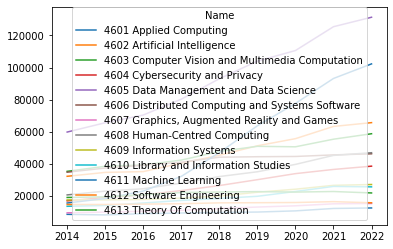

In [78]:
import matplotlib.pyplot as plt
plt.figure()
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
df_plot = df_data[(df_data['Code'].astype(str).str.len() == 4) & (df_data['Code'].astype(str).str.startswith("46"))].set_index("Name")
df_plot = df_plot.iloc[:, 1:-1]
df_plot[df_plot.columns[df_plot.columns.isin([2014,2015,2016,2017,2018,2019,2020,2021,2022])]].T.plot()
plt.show()